_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Sascha Mühlinghaus, Max Bardelang

LLM Disclaimer: ChatGPT for help with data analysis, Perplexity for literature search and Copilot for repetitive code tasks.

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
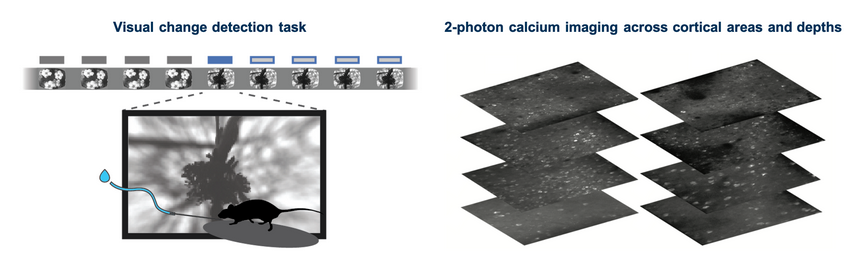

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

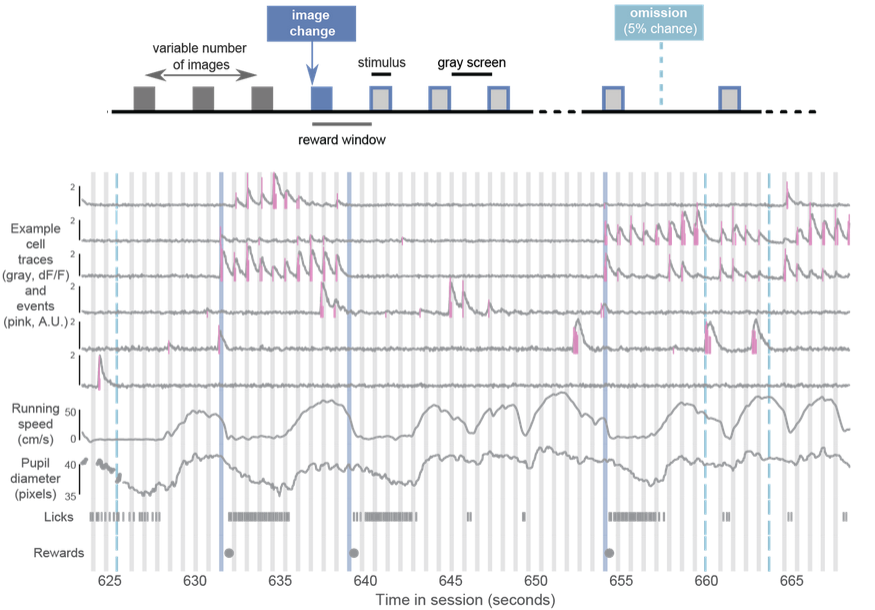

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [83]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy import optimize as opt
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import hsv_to_rgb, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import random

jupyter_black.load()
from typing import Tuple

from joblib import Parallel, delayed
from tqdm import tqdm
import time
import oopsi

from oasis.functions import (
    gen_data,
    gen_sinusoidal_data,
    deconvolve,
    estimate_parameters,
)
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

In [4]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["frequency", "direction", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(
    path="/Users/sascha/Library/Mobile Documents/com~apple~CloudDocs/Uni_Tübingen/Semester2/NeuralDataScience/Assignments/FinalProject/data/project-01"
)  # adjust the path as necessary

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure in the preferred orientation/direction/frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of:
1. Pre-processing
2. Spike inference
3. Tuning function fitting
4. Statistical testing.

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

# Implementation

We are following these steps to answer the questions:

We filter the data to have smoother signals by cutting out low frequencies to be able to detect spikes in high-frequency components.
We then calculate the threshold for spikes and detect positions of spikes in the filtered data.
Because we are interested in the specificity of neurons to stimuls characteristics we look at each trial of stimulus presentation and segment the reactions of neurons in each stimulus segment.
Since only certain trials show detect spikes we filter out trials for each neurons in which spikes occur to continue the analysis with these.
We then correct each stimulus reaction to the baseline activity of the neuron before the stimulus presentation.
We then fit tuning curves to the detected spikes after stimulus presentation and by permutation analysis check which neurons have certain orientation, direction and frequency preference.
Then using the mask we plot the entire filed of neurons with their respective preference to first check if we can visually see an organization of the neurons into columns.
We statistically analyze this by ...



## 1 Pre-processing

### 1.1 Data Exploration

We start by looking at what the the raw data looks like for one example neuron:

In [242]:
running_speed = data["running_speed"][1]
running_speed

array([   9.67741,    9.71067,    9.74392, ..., 3849.55347, 3849.58673,
       3849.61999], shape=(115471,))

At first we have a look at the raw data for one neuron, which is stored in a dictionary called `data`.

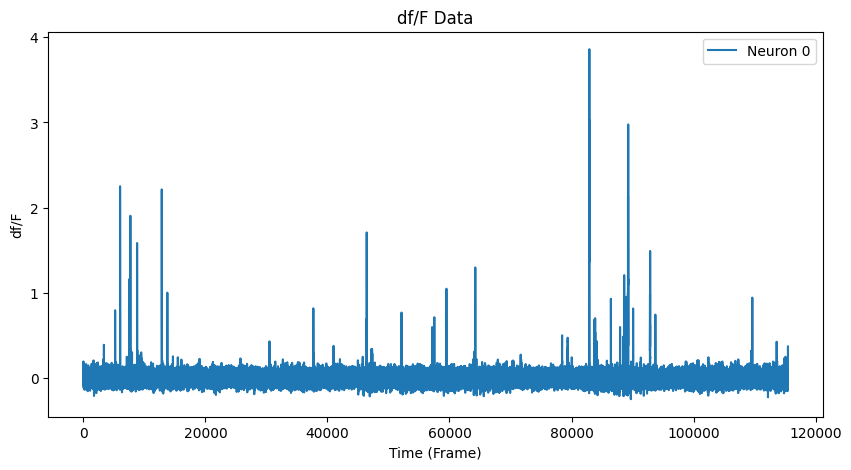

In [ ]:
# plot the dff data for a given neuron
neuron = 0
dff = data["dff"]
t = data["t"]
stim = data["stim_table"]
set = data["stim_epoch_table"]

plt.figure(figsize=(10, 5))
plt.plot(
    dff[neuron],
    label=f"Neuron {neuron}",
)
plt.title("df/F Data")
plt.xlabel("Time (Frame)")
plt.ylabel("df/F")
plt.legend()
plt.show()

Let's look at the first drifting gratings stimulus epoch for the first neuron in the dataset. We will plot the dF/F data for this neuron over time.

Text(0, 0.5, 'DFF')

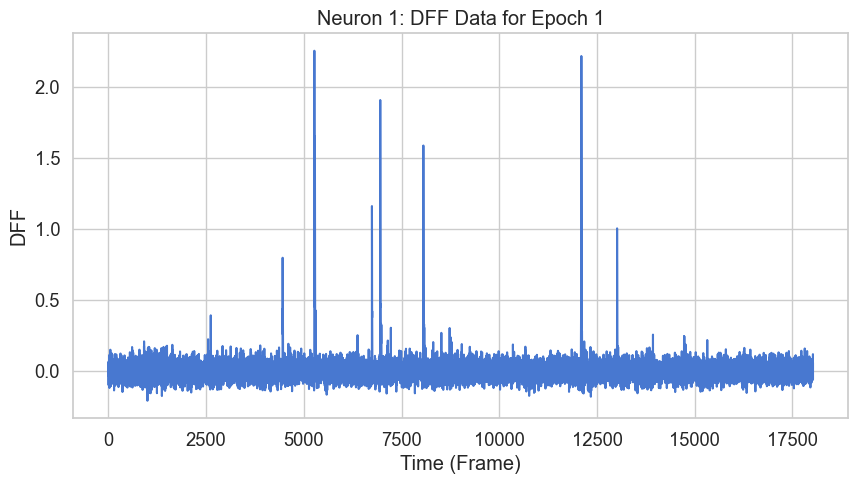

In [ ]:
# Epoch 1: drifting grating stimulus [747, 18775]

start, end = data["stim_epoch_table"].iloc[0][["start", "end"]]
neuron = 0  # Specify the neuron index to plot
plt.figure(figsize=(10, 5))
plt.plot(
    dff[neuron][start:end],
    label=f"Neuron {neuron} - Epoch 1",
)
plt.title("Neuron 1: DFF Data for Epoch 1")
plt.xlabel("Time (Frame)")
plt.ylabel("df/F")

To see more of the frequency structure let´s look at a spcific segment of the data:

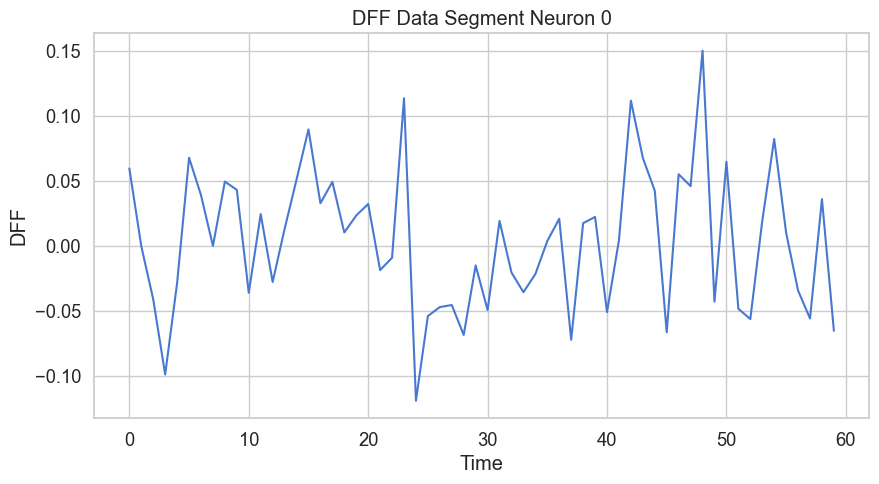

In [ ]:
# look at specific trial / segment of the data for the example neuron
plt.figure(figsize=(10, 5))

# extract stimulus trial for the example neuron
stim_trial = data["stim_table"].iloc[0]  # First stimulus trial
start, end = int(stim_trial["start"]), int(stim_trial["end"])

plt.plot(
    data["dff"][0][start:end],
    label="Neuron 0",
)
plt.title("df/F Data Segment Neuron 0")
plt.xlabel("Time")
plt.ylabel("df/F")
plt.show()

When inspecting multiple neurons, we also see a lot of variance across them. Hence, the data is not normalized and to be able to better detect artefacts like spikes we need to highpass filter, smooth and normalize the data. In the following we will look more closely at how the epochs and trials are structured in the data. Each trial is about 60 frames long but sometimes also a bit longer or shorter. We also see that the epochs have diferent lengths.

In [7]:
# get length of trials by
trial_length = np.array([row.end - row.start for _, row in stim.iterrows()])
print(f"Unique trial lengths: {np.unique(trial_length)}")

Unique trial lengths: [59. 60. 61.]


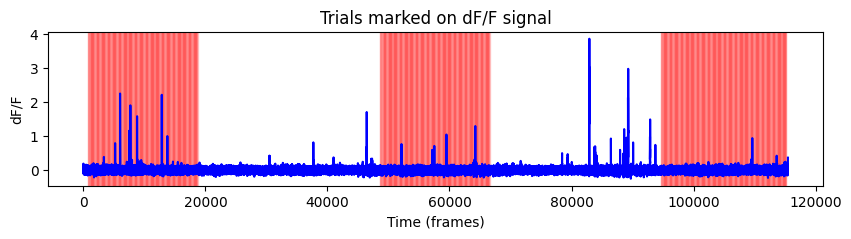

In [9]:
def mark_trials(ax, stim_table, color="red", alpha=0.5):
    for _, row in stim_table.iterrows():
        ax.axvspan(row.start, row.end, color=color, alpha=alpha)


fig, ax = plt.subplots(figsize=(10, 2))
mark_trials(ax, stim, color="red", alpha=0.2)
ax.plot(dff[neuron], label=f"Neuron {neuron}", color="blue")
ax.set_xlabel("Time (frames)")
ax.set_ylabel("dF/F")
ax.set_title("Trials marked on dF/F signal")
plt.show()

For the sake of simplicity we will put the trials and epochs into a single dataframe.

### 1.2 Data Segmentation

There are stimulus epochs with a drifting grating stimulus which we have to extract from the data. We can use the `stim_epoch_table` to segment the data into these epochs. Additionally, we can use the `stim_table` to get the parameters of the stimulus (e.g. frequency, direction, etc.) and the trials of the epochs.

In [15]:
# drop blank sweeps
stim = stim[stim["blank_sweep"] == 0].reset_index(drop=True)
stim

,frequency,direction,blank_sweep,start,end
0,1.0,225.0,0.0,747,807
1,2.0,180.0,0.0,837,897
2,4.0,90.0,0.0,927,987
3,1.0,270.0,0.0,1018,1077
4,4.0,135.0,0.0,1108,1168
...,...,...,...,...,...
593,4.0,315.0,0.0,114794,114854
594,2.0,45.0,0.0,114884,114944
595,4.0,180.0,0.0,114975,115034
596,4.0,270.0,0.0,115065,115125


In [16]:
set

,stimulus,start,end
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


The values of start and end in the `stim_epoch_table` are in frames, so we can use these to segment the data into epochs. We can also use the `stim` to get the parameters of the stimulus (e.g. frequency, direction, etc.) and the trials of the epochs.

In [17]:
dff = data["dff"]
trials = stim
stim_epoch = set

# convert start and end columns to integers
stim_epoch["start"] = stim_epoch["start"].astype(int)
stim_epoch["end"] = stim_epoch["end"].astype(int)
trials["start"] = trials["start"].astype(int)
trials["end"] = trials["end"].astype(int)

df = pd.DataFrame(dff.T)

# name row index "neuron"
df.columns.name = "neuron"
# name columns "frame"
df.index.name = "frame"
# get only drifting gratings epochs
drifting_epochs = stim_epoch[stim_epoch["stimulus"] == "drifting_gratings"].reset_index(
    drop=True
)
# cut out drifting grating epochs
records = []
for i, row in drifting_epochs.iterrows():
    # get all neurons in this epoch
    epoch_df = df.loc[row.start : row.end, :]
    # add epoch number as column index
    epoch_df.index = pd.MultiIndex.from_product(
        [[i], epoch_df.index], names=["epoch", "frame"]
    )
    # add to records
    records.append(epoch_df)
# create dataframe from records
df_raw = pd.concat(records, axis=0)
df_raw

neuron             0         1         2         3         4         5    \
epoch frame                                                                
0     747     0.059512 -0.063161 -0.019814 -0.064979  0.067324  0.021476   
      748    -0.000203 -0.049975  0.030449  0.041945  0.006195 -0.014444   
      749    -0.041120 -0.068027  0.055002 -0.067749 -0.005289 -0.046250   
      750    -0.098806  0.074266 -0.006529  0.006800  0.031468  0.046876   
      751    -0.028460  0.028866  0.051883  0.115626  0.001330  0.075100   
...                ...       ...       ...       ...       ...       ...   
2     115211 -0.012725  0.011566  0.043530  0.018481 -0.075041  0.010294   
      115212 -0.012888  0.003882  0.037825 -0.063592 -0.007616  0.039843   
      115213  0.044822 -0.022734 -0.016276 -0.086995 -0.020194  0.031156   
      115214 -0.055499 -0.053176 -0.048795 -0.084779 -0.009320  0.068994   
      115215 -0.109390 -0.006519 -0.077936 -0.056792 -0.002331 -0.035282   

neuron             6         7         8         9    ...       96        97   \
epoch frame                                           ...                       
0     747    -0.025787 -0.000141 -0.006664  0.036956  ... -0.043115 -0.005537   
      748    -0.008338  0.031437  0.049524 -0.037182  ...  0.033092  0.003726   
      749    -0.029259  0.101742 -0.025278 -0.051245  ...  0.004700  0.035787   
      750     0.001280  0.008053  0.017523 -0.021524  ...  0.134587 -0.001434   
      751     0.028452 -0.049464  0.017742  0.041560  ...  0.048615  0.008920   
...                ...       ...       ...       ...  ...       ...       ...   
2     115211  0.042833  0.066424  0.898020 -0.021838  ...  0.024481  0.041598   
      115212 -0.028717 -0.042497  1.191723 -0.051500  ... -0.069082  0.071589   
      115213 -0.014092  0.032496  1.026063  0.034322  ...  0.012087  0.132241   
      115214 -0.072743 -0.098667  0.824707  0.031996  ... -0.022002  0.036148   
      115215 -0.036401 -0.003220  0.890062  0.022936  ... -0.037532  0.062050   

neuron             98        99        100       101       102       103  \
epoch frame                                                                
0     747    -0.001483  0.153535 -0.008959  0.014240  0.085813 -0.066683   
      748     0.068913  0.086297 -0.010431 -0.006715  0.055087 -0.052482   
      749    -0.012316  0.001702  0.012815  0.050914  0.083215  0.037526   
      750     0.026124 -0.091168 -0.010381  0.124242 -0.003417  0.056991   
      751     0.071050  0.019964  0.102945  0.093136  0.005253  0.023856   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.021203  0.112598  0.065437 -0.012071 -0.021133 -0.037243   
      115212 -0.035257  0.040120  0.061543 -0.072416 -0.005645  0.014365   
      115213 -0.005524  0.031642 -0.005066  0.048101 -0.041793 -0.017129   
      115214 -0.013789 -0.022765 -0.005168 -0.026585  0.003097 -0.021029   
      115215  0.051854  0.094462 -0.049081  0.000000 -0.024927  0.000970   

neuron             104       105  
epoch frame                       
0     747     0.046780  0.036651  
      748     0.187832  0.028809  
      749     0.100032  0.009712  
      750     0.168290  0.026584  
      751     0.035082  0.137172  
...                ...       ...  
2     115211 -0.053058 -0.018237  
      115212 -0.014696 -0.000033  
      115213  0.006574 -0.077658  
      115214 -0.017389  0.000000  
      115215 -0.068638 -0.009105  

[56615 rows x 106 columns]

Now we have put together the trials, epochs and our timeseries data into a single dataframe. 

After having created a dataframe with the segmented data and having filtered out the blank sweeps we can start the actual preprocessing of the timeseries data. We have seen that there are a lot of high frequency components in the data which we want to filter out to be able to detect spikes in the data. We can use a butter bandpass filter to cut out high frequencies and filtfilt function to apply the filter to the data without introducing phase shifts.

In [30]:
# estimate the sampling frequency
dt = np.mean(np.diff(data["t"]))
print("dt:", dt)
fs = np.round(1 / dt)
print("fs:", fs)
cut_off = 0.5  # cutoff frequency for the filter
print("cut_off:", cut_off)

dt: 0.03325489373863341
fs: 30.0
cut_off: 0.5


### 1.3 Filtering, Normalization and Smoothing

The smoothing has been adapted from Yaksi and Friedrich (2006) and the normalization and filtering is based on the methods of Vogelstein et al. (2020). The steps are as follows:
1. **Filtering**: We apply a bandpass filter to the data to remove high frequency noise. This helps in isolating the relevant frequency components of the calcium signals.
2. **Normalization**: The filtered signals are then normalized to have a consistent baseline, which is crucial for comparing activity across different neurons and epochs.
3. **Smoothing**: Finally, we apply a smoothing algorithm to reduce any remaining noise and artifacts, ensuring that the extracted signals more accurately reflect the underlying neural activity.

In [21]:
def highpass_filter(group, fs=30, cutoff=0.5):
    """
    Apply highpass filter to each trace in the group.

    Parameters:
    - group: DataFrame with trace
    - fs: sampling frequency (Hz)
    - cutoff: cutoff frequency (Hz)

    Returns: DataFrame with filtered traces
    """
    nyq = 0.5 * fs
    # normalize the cutoff frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(4, normal_cutoff, btype="low", analog=False)
    filtered = filtfilt(b, a, group.values)
    return pd.Series(filtered, index=group.index.get_level_values("frame"))


def normalize_trace(group):
    """Normalize the trace to the range [0, 1].

    Parameters:
    - group: DataFrame with trace
    """

    f_min = group.values.min()
    f_max = group.values.max()
    return pd.Series(
        (group.values - f_min) / (f_max - f_min),
        index=group.index.get_level_values("frame"),
    )


def smooth_trace(group, thr_noise=1.0, max_iter=5000):
    """
    smooth the trace using iterative local averaging based on peak amplitude differences

    parameters:
    - group: series with calcium trace (df/f values)
    - thr_noise: noise threshold for peak amplitude differences
    - max_iter: maximum number of smoothing iterations

    returns:
    - smoothed trace as a pandas series with same index as input
    """
    trace = group.values.copy()
    smoothed = trace.copy()
    iteration = 0

    while iteration < max_iter:
        peaks, _ = find_peaks(smoothed)
        if len(peaks) < 2:
            break

        amp_diffs = np.diff(smoothed[peaks])
        amp_diffs = np.insert(amp_diffs, 0, np.inf)
        pmin_idx = np.argmin(np.abs(amp_diffs))

        if abs(amp_diffs[pmin_idx]) >= thr_noise:
            break

        if pmin_idx == 0 or pmin_idx == len(peaks) - 1:
            break

        start = peaks[pmin_idx - 1]
        end = peaks[pmin_idx + 1]

        segment = smoothed[start : end + 1].copy()
        for _ in range(3):
            segment[1:-1] = (segment[:-2] + segment[1:-1] + segment[2:]) / 3

        smoothed[start : end + 1] = segment
        iteration += 1

    return pd.Series(smoothed, index=group.index.get_level_values("frame"))

PLACEHOLDER: explain and cite highpass filering and normalization.  
PLACEHOLDER: explain and cite smoothing

In [22]:
df_preprocessed = (
    df_raw.stack("neuron")
    .groupby(["neuron", "epoch"])
    .apply(highpass_filter, fs=30, cutoff=0.5)
    .groupby(["neuron", "epoch"])
    .apply(normalize_trace)
    .groupby(["neuron", "epoch"])
    .apply(smooth_trace)
    .unstack("neuron")
)
df_preprocessed.reset_index(inplace=False)
df_preprocessed

neuron             0         1         2         3         4         5    \
epoch frame                                                                
0     747     0.205041  0.000000  0.201189  0.000000  0.233279  0.136643   
      748     0.203099  0.013988  0.207664  0.083451  0.226652  0.136581   
      749     0.201018  0.029092  0.214076  0.164982  0.219969  0.136485   
      750     0.198810  0.045323  0.220386  0.244210  0.213259  0.136357   
      751     0.196490  0.062691  0.226558  0.320767  0.206552  0.136196   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.105004  0.751521  0.211653  0.191105  0.249700  0.416030   
      115212  0.102587  0.753420  0.210046  0.188176  0.249458  0.414285   
      115213  0.100458  0.754911  0.208609  0.185596  0.249243  0.412750   
      115214  0.098608  0.756056  0.207341  0.183355  0.249056  0.411419   
      115215  0.097025  0.756914  0.206241  0.181439  0.248895  0.410285   

neuron             6         7         8         9    ...       96        97   \
epoch frame                                           ...                       
0     747     0.018682  0.322033  0.082538  0.200014  ...  0.233229  0.118694   
      748     0.047830  0.323275  0.082832  0.192659  ...  0.234341  0.120671   
      749     0.076337  0.324388  0.083138  0.185596  ...  0.235668  0.122686   
      750     0.104067  0.325378  0.083456  0.178846  ...  0.237190  0.124733   
      751     0.130897  0.326253  0.083781  0.172430  ...  0.238891  0.126809   
...                ...       ...       ...       ...  ...       ...       ...   
2     115211  0.181564  0.311854  0.623758  0.296327  ...  0.119356  0.271637   
      115212  0.179029  0.310743  0.628029  0.296992  ...  0.119191  0.272657   
      115213  0.176845  0.309815  0.631623  0.297558  ...  0.119042  0.273516   
      115214  0.174989  0.309051  0.634601  0.298033  ...  0.118910  0.274228   
      115215  0.173436  0.308434  0.637030  0.298425  ...  0.118795  0.274809   

neuron             98        99        100       101       102       103  \
epoch frame                                                                
0     747     0.130797  0.738727  0.153955  0.308356  0.593111  0.000000   
      748     0.135532  0.698372  0.156253  0.310692  0.573582  0.045764   
      749     0.140065  0.658536  0.158496  0.312839  0.554248  0.090861   
      750     0.144377  0.619374  0.160670  0.314761  0.535201  0.135096   
      751     0.148452  0.581034  0.162761  0.316420  0.516527  0.178283   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.184942  0.423950  0.057382  0.228786  0.116550  0.445820   
      115212  0.185161  0.426335  0.057227  0.228633  0.116441  0.446283   
      115213  0.185360  0.428406  0.057083  0.228490  0.116342  0.446679   
      115214  0.185540  0.430179  0.056951  0.228359  0.116253  0.447013   
      115215  0.185698  0.431674  0.056833  0.228242  0.116174  0.447291   

neuron             104       105  
epoch frame                       
0     747     0.192719  0.599603  
      748     0.192648  0.607922  
      749     0.192511  0.616153  
      750     0.192308  0.624205  
      751     0.192039  0.631981  
...                ...       ...  
2     115211  0.112896  0.249596  
      115212  0.112401  0.249396  
      115213  0.111980  0.249241  
      115214  0.111625  0.249123  
      115215  0.111330  0.249036  

[56615 rows x 106 columns]

The filtering process has smoothed the signal, reducing noise while preserving the essential features of the neural activity. 

Text(0.5, 0.98, 'Inspect preprocessed and raw data')

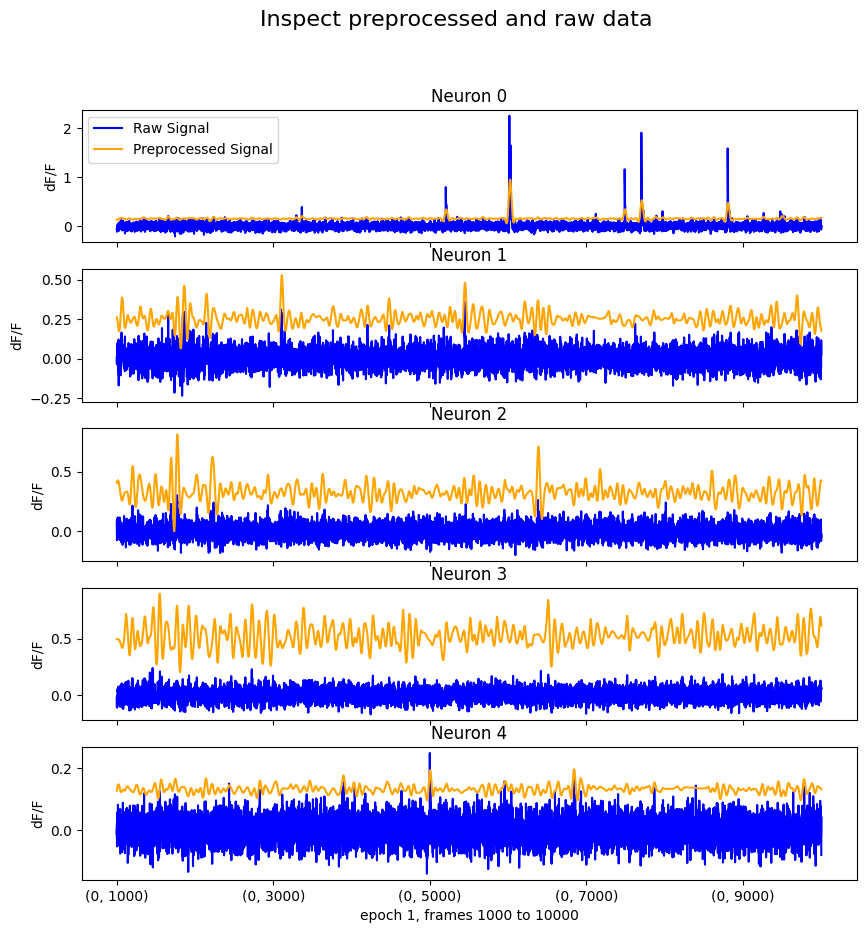

In [26]:
# plot raw and filtered signal epoch 1 of neurons 0-4
neuron_indices = range(0, 5)  # Neuron indices to plot
interval = slice(1000, 10000)  # Interval to plot
fig, axes = plt.subplots(len(neuron_indices), 1, figsize=(10, 10), sharex=True)

for i, neuron in enumerate(neuron_indices):
    ax = axes[i]
    df_raw.loc[(0, interval), neuron].plot(ax=ax, label="Raw Signal", color="blue")
    df_preprocessed.loc[(0, interval), neuron].plot(
        ax=ax, label="Preprocessed Signal", color="orange"
    )
    ax.set_title(f"Neuron {neuron}")
    ax.set_ylabel("dF/F")
    ax.set_xlabel(f"epoch 1, frames {interval.start} to {interval.stop}")
    if i == 0:
        ax.legend()

# set title for the entire figure
fig.suptitle("Inspect preprocessed and raw data", fontsize=16)

The preprocessing of the data is important for the subsequent analysis steps, as it ensures that the signals are clean and ready for spike inference and tuning function fitting. 

PLACEHOLDER: explain and cite oopsi.  
PLACEHOLDER: explain and cite oasis

## 2 Spike Inference

### 2.1 Spike Inference with OOPSI

In [37]:
def apply_oopsi(group, dt=1 / 30):
    """
    apply oopsi deconvolution to a trace group and return results as pd.Series

    parameters:
    - group: pd.Series (dF/F values for one neuron × epoch)
    - dt: time step in seconds

    returns:
    - pd.Series with spike train (n) indexed by frame
    """
    trace = group.values.astype(np.float64)
    n, _ = oopsi.fast(trace, dt=dt, iter_max=100, update=True)
    return pd.Series(n, index=group.index)


def apply_oopsi_parallel(df, dt=1 / 30, n_jobs=4):
    """
    parallel apply of oopsi deconvolution across neuron × epoch groups

    parameters:
    - df: multi-index dataframe (epoch, frame) × neuron
    - dt: time step (default 1/30 for 30 Hz)
    - n_jobs: number of parallel jobs

    returns:
    - dataframe with spike estimates (same shape as df)
    """
    # stack to long format: index = (epoch, frame), columns = neuron → becomes Series
    df_stacked = df.stack("neuron")

    # group by neuron and epoch
    grouped = df_stacked.groupby(["neuron", "epoch"])

    print("running oopsi in parallel per (neuron, epoch)...")
    start = time.time()

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(apply_oopsi)(group, dt)
        for _, group in tqdm(grouped, total=len(grouped))
    )

    print(f"done in {time.time() - start:.2f} seconds.")

    # combine results and reshape
    df_oopsi = pd.concat(
        results, keys=grouped.groups.keys(), names=["neuron", "epoch", "frame"]
    )
    df_oopsi = df_oopsi.unstack("neuron")

    return df_oopsi


# df_oopsi = apply_oopsi_parallel(df_preprocessed, dt=1 / 30, n_jobs=4)
df_oopsi = pd.read_pickle("df_oopsi.pkl")

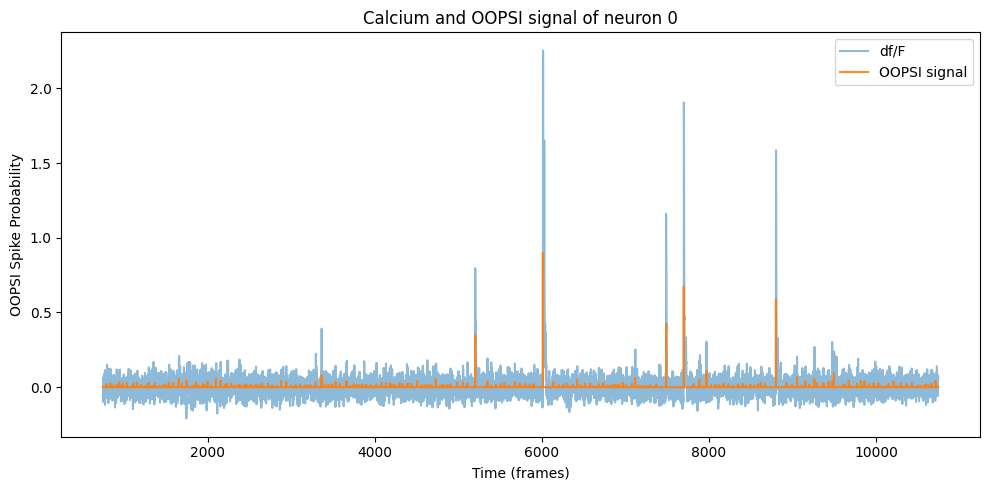

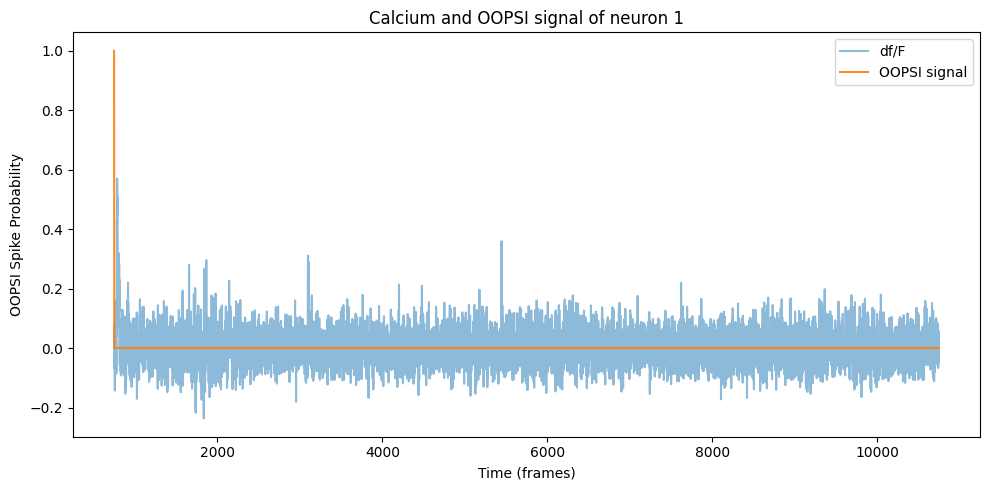

In [39]:
plot_lim = 10000  # number of frames to show

for i, neuron in enumerate(df_raw.columns[0:2]):
    plt.figure(figsize=(10, 5))

    # plot raw trace
    plt.plot(
        df_raw.index.get_level_values("frame")[:plot_lim],
        df_raw[neuron].values[:plot_lim],
        alpha=0.5,
        label="df/F",
    )

    # plot OOPSI raw trace
    plt.plot(
        df_raw.index.get_level_values("frame")[:plot_lim],
        df_oopsi[neuron][:plot_lim],
        alpha=0.9,
        label="OOPSI signal",
    )

    plt.title(f"Calcium and OOPSI signal of neuron {neuron}")
    plt.xlabel("Time (frames)")
    plt.ylabel("OOPSI Spike Probability")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 2.2 Spike Inference with OASIS

For Oasis we use the raw data as it performs better on the raw data than on the filtered data. However, we are also performing a parameter search to find the best parameters for the spike inference. Most of the code is adapted from the Oasis documentation.

Best parameters for each neuron:
{0: (np.float64(0.1), np.float64(0.1)), 1: (np.float64(0.1), np.float64(0.4)), 2: (np.float64(0.1), np.float64(0.30000000000000004)), 3: (np.float64(0.1), np.float64(0.5)), 4: (np.float64(0.1), np.float64(0.1)), 5: (np.float64(0.1), np.float64(0.1)), 6: (np.float64(0.1), np.float64(0.1)), 7: (np.float64(0.1), np.float64(0.6)), 8: (np.float64(0.1), np.float64(0.1)), 9: (np.float64(0.1), np.float64(0.1)), 10: (np.float64(0.1), np.float64(0.1)), 11: (np.float64(0.1), np.float64(0.1)), 12: (np.float64(0.1), np.float64(0.1)), 13: (np.float64(0.1), np.float64(0.6)), 14: (np.float64(0.1), np.float64(0.4)), 15: (np.float64(0.1), np.float64(0.1)), 16: (np.float64(0.1), np.float64(0.5)), 17: (np.float64(0.1), np.float64(0.1)), 18: (np.float64(0.1), np.float64(0.1)), 19: (np.float64(0.1), np.float64(0.1)), 20: (np.float64(0.1), np.float64(0.1)), 21: (np.float64(0.1), np.float64(0.1)), 22: (np.float64(0.1), np.float64(0.1)), 23: (np.float64(0.1), np.float64(0.1)), 

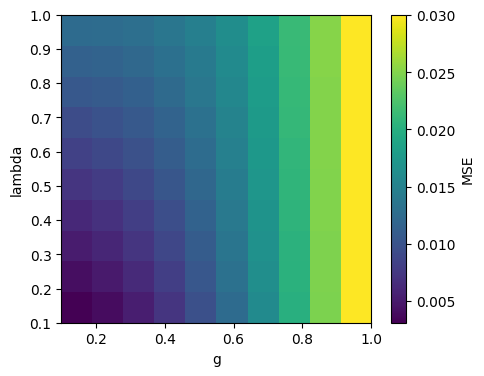

In [27]:
determine_parameters = True

# parameter search space
lam_values = np.linspace(0.1, 1.0, 10)
g_values = np.linspace(0.1, 1.0, 10)

if determine_parameters:
    # evaluate the performance of deconvolution for different parameter combinations
    def evaluate_performance(true_signal, inferred_signal):
        mse = np.mean((true_signal - inferred_signal) ** 2)
        return mse

    # grid search
    best_params = {}
    best_performance = {}
    performance_grid = np.zeros((len(lam_values), len(g_values)))

    for neuron in df_raw.columns:
        best_mse = float("inf")
        best_lam = None
        best_g = None

        for lam_i, lam in enumerate(lam_values):
            for gi, g in enumerate(g_values):
                try:
                    # convert trace to float64 for oasisAR1 compatibility
                    trace = df_raw[neuron].values.astype(np.float64)
                    inferred_signal = oasisAR1(trace, g, lam)[1]
                    mse = evaluate_performance(trace, inferred_signal)
                    performance_grid[lam_i, gi] += mse
                except Exception as e:
                    print(f"An error occurred: {e}")
                    continue

                if mse < best_mse:
                    best_mse = mse
                    best_lam = lam
                    best_g = g

        if best_lam is not None and best_g is not None:
            best_params[neuron] = (best_lam, best_g)
            best_performance[neuron] = best_mse
        else:
            print(f"Skipping neuron {neuron} due to invalid parameters.")

    print("Best parameters for each neuron:")
    print(best_params)
    # ensure best_params and best_performance are not empty before calculating averages
    if best_params and best_performance:
        print("Best parameters averaged over all neurons:")
        print(np.mean(list(best_params.values()), axis=0))
        print("Best performance averaged over all neurons:")
        print(np.mean(list(best_performance.values())))
    else:
        print("No valid parameters found for any neuron.")
    print("Best parameters averaged over all neurons:")
    print(np.mean(list(best_params.values()), axis=0))
    print("Best performance averaged over all neurons:")
    print(np.mean(list(best_performance.values())))

    # average the performance across all neurons
    performance_grid /= len(df_raw.columns)

    # save performance grid as .npy file
    np.save("performance_grid.npy", performance_grid)

else:
    # load performance grid
    performance_grid = np.load("performance_grid.npy")

# plot performance grid
plt.figure(figsize=(5, 4))
plt.imshow(
    performance_grid,
    origin="lower",
    aspect="auto",
    extent=[g_values[0], g_values[-1], lam_values[0], lam_values[-1]],
)
plt.colorbar(label="MSE")
plt.xlabel("g")
plt.ylabel("lambda")
plt.show()

In [ ]:
def apply_oasis(group):
    """
    Apply the OASIS algorithm to the group of traces.

    Parameters:
    - group: DataFrame with raw traces

    Returns: Series with deconvolved traces
    """
    trace = group.values.copy().astype(
        np.float64
    )  # ensure trace is float64 for Cython compatibility
    c, s = oasisAR1(trace, g=best_g, lam=best_lam)
    return pd.Series(s, index=group.index.get_level_values("frame"))


df_oasis = (
    df_raw.stack("neuron")
    .groupby(["neuron", "epoch"])
    .apply(apply_oasis)
    .unstack("neuron")
)
df_oasis


neuron        0        1         2         3    4    5    6         7    \
epoch frame                                                               
0     747     0.0  0.00000  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      748     0.0  0.00000  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      749     0.0  0.00000  0.000000  0.000000  0.0  0.0  0.0  0.002036   
      750     0.0  0.00189  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      751     0.0  0.00000  0.001883  0.065626  0.0  0.0  0.0  0.000000   
...           ...      ...       ...       ...  ...  ...  ...       ...   
2     115211  0.0  0.00000  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      115212  0.0  0.00000  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      115213  0.0  0.00000  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      115214  0.0  0.00000  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      115215  0.0  0.00000  0.000000  0.000000  0.0  0.0  0.0  0.000000   

neuron             8    9    ...       96        97   98        99        100  \
epoch frame                  ...                                                
0     747     0.000000  0.0  ...  0.000000  0.000000  0.0  0.000000  0.000000   
      748     0.000000  0.0  ...  0.000000  0.000000  0.0  0.000000  0.000000   
      749     0.000000  0.0  ...  0.000000  0.000000  0.0  0.000000  0.000000   
      750     0.000000  0.0  ...  0.056672  0.000000  0.0  0.000000  0.000000   
      751     0.000000  0.0  ...  0.000000  0.000000  0.0  0.000000  0.012074   
...                ...  ...  ...       ...       ...  ...       ...       ...   
2     115211  0.328084  0.0  ...  0.000000  0.000000  0.0  0.030656  0.000000   
      115212  0.717713  0.0  ...  0.000000  0.000000  0.0  0.000000  0.000000   
      115213  0.405202  0.0  ...  0.000000  0.032399  0.0  0.000000  0.000000   
      115214  0.286676  0.0  ...  0.000000  0.000000  0.0  0.000000  0.000000   
      115215  0.402708  0.0  ...  0.000000  0.000000  0.0  0.000000  0.000000   

neuron             101  102  103       104       105  
epoch frame                                           
0     747     0.000000  0.0  0.0  0.000000  0.000000  
      748     0.000000  0.0  0.0  0.130279  0.000000  
      749     0.000914  0.0  0.0  0.000000  0.000000  
      750     0.055935  0.0  0.0  0.056095  0.000000  
      751     0.000000  0.0  0.0  0.000000  0.087172  
...                ...  ...  ...       ...       ...  
2     115211  0.000000  0.0  0.0  0.000000  0.000000  
      115212  0.000000  0.0  0.0  0.000000  0.000000  
      115213  0.000000  0.0  0.0  0.000000  0.000000  
      115214  0.000000  0.0  0.0  0.000000  0.000000  
      115215  0.000000  0.0  0.0  0.000000  0.000000  

[56615 rows x 106 columns]

In [32]:
df_oasis_filtered = (
    df_preprocessed.stack("neuron")
    .groupby(["neuron", "epoch"])
    .apply(apply_oasis)
    .unstack("neuron")
)
df_oasis_filtered

neuron             0         1         2         3         4         5    \
epoch frame                                                                
0     747     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      748     0.034091  0.000000  0.039426  0.000000  0.051997  0.000000   
      749     0.032398  0.000000  0.044543  0.004982  0.046639  0.000000   
      750     0.030606  0.000000  0.049571  0.083213  0.041265  0.000000   
      751     0.028728  0.000000  0.054481  0.143925  0.035900  0.000000   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.000000  0.473691  0.040967  0.024227  0.071706  0.204432   
      115212  0.000000  0.475116  0.039715  0.021955  0.071518  0.203079   
      115213  0.000000  0.476227  0.038600  0.019961  0.071351  0.201893   
      115214  0.000000  0.477074  0.036999  0.013768  0.071207  0.200869   
      115215  0.000000  0.437703  0.000000  0.000000  0.031084  0.160001   

neuron             6         7         8         9    ...       96        97   \
epoch frame                                           ...                       
0     747     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
      748     0.000000  0.130868  0.000000  0.024657  ...  0.059695  0.000000   
      749     0.000000  0.131733  0.000000  0.019064  ...  0.060799  0.000000   
      750     0.000000  0.132500  0.000000  0.013727  ...  0.062057  0.000000   
      751     0.000000  0.133177  0.000000  0.008661  ...  0.063453  0.000000   
...                ...       ...       ...       ...  ...       ...       ...   
2     115211  0.016670  0.121221  0.372008  0.109216  ...  0.000000  0.089549   
      115212  0.014716  0.120373  0.375277  0.109727  ...  0.000000  0.090329   
      115213  0.013039  0.119666  0.378017  0.110160  ...  0.000000  0.090984   
      115214  0.005935  0.119088  0.380277  0.110521  ...  0.000000  0.091525   
      115215  0.000000  0.078623  0.342110  0.070818  ...  0.000000  0.051963   

neuron             98        99        100       101       102       103  \
epoch frame                                                                
0     747     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      748     0.000000  0.422626  0.000000  0.121020  0.326960  0.000000   
      749     0.000000  0.390861  0.000000  0.122701  0.311532  0.000000   
      750     0.000000  0.359667  0.000670  0.124193  0.296351  0.000000   
      751     0.000000  0.329159  0.002627  0.125468  0.281486  0.018283   
...                ...       ...       ...       ...       ...       ...   
2     115211  0.020001  0.211703  0.000000  0.054997  0.000000  0.228763   
      115212  0.020173  0.213545  0.000000  0.054876  0.000000  0.229119   
      115213  0.020328  0.215139  0.000000  0.054763  0.000000  0.229422   
      115214  0.016735  0.216498  0.000000  0.054661  0.000000  0.229678   
      115215  0.000000  0.177638  0.000000  0.014570  0.000000  0.189888   

neuron             104       105  
epoch frame                       
0     747     0.000000  0.000000  
      748     0.026104  0.360001  
      749     0.025981  0.366569  
      750     0.025806  0.372974  
      751     0.025577  0.379140  
...                ...       ...  
2     115211  0.000000  0.071626  
      115212  0.000000  0.071477  
      115213  0.000000  0.071362  
      115214  0.000000  0.071275  
      115215  0.000000  0.031212  

[56615 rows x 106 columns]

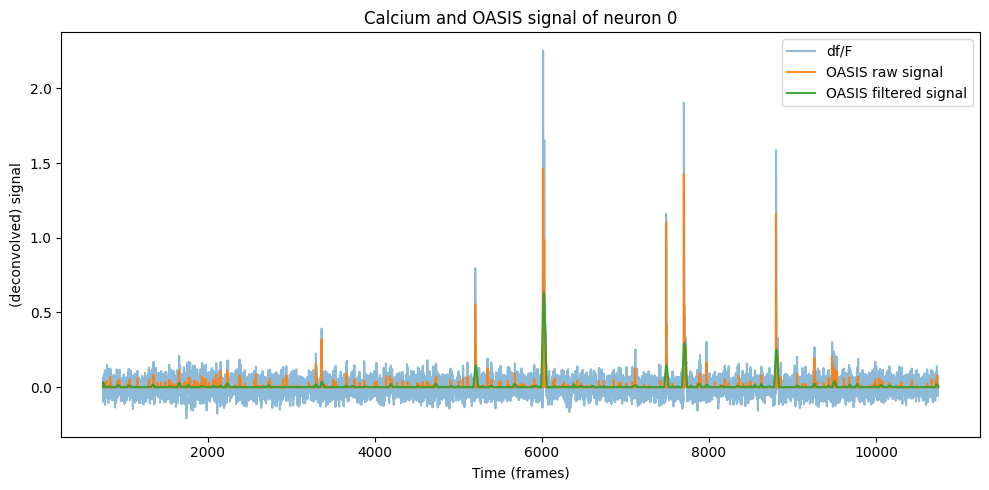

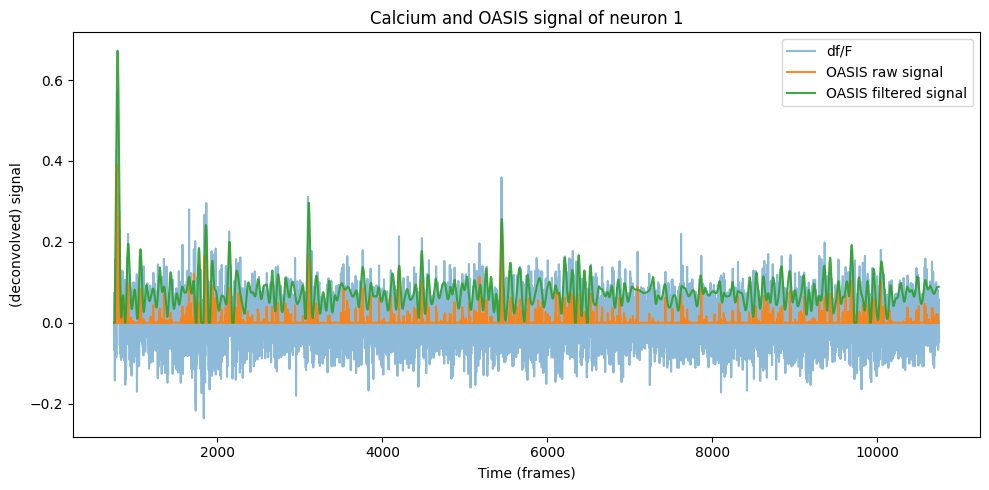

In [36]:
determine_parameters = False  # set to True if you want to run the grid search
# set best parameters from grid search (or manually)
if determine_parameters:
    best_g = np.mean(list(best_params.values()), axis=0)[1]
    best_lam = np.mean(list(best_params.values()), axis=0)[0]
else:
    best_g = 0.2
    best_lam = 0.2

sampling_rate = 1 / fs  # fs must be defined earlier

# run deconvolution using oasisAR1
ds_oasis = []
for neuron in df_raw.columns:
    # cast to float64 for Cython compatibility
    y = df_raw[neuron].values.astype(np.float64)
    c, s = oasisAR1(y, g=best_g, lam=best_lam)
    ds_oasis.append(c)

plot_lim = 10000  # number of frames to show

for i, neuron in enumerate(df_raw.columns[0:2]):
    plt.figure(figsize=(10, 5))

    # plot raw trace
    plt.plot(
        df_raw.index.get_level_values("frame")[:plot_lim],
        df_raw[neuron].values[:plot_lim],
        alpha=0.5,
        label="df/F",
    )

    # plot OASIS raw trace
    plt.plot(
        df_raw.index.get_level_values("frame")[:plot_lim],
        df_oasis[neuron][:plot_lim],
        alpha=0.9,
        label="OASIS raw signal",
    )
    # plot OASIS filtered trace
    plt.plot(
        df_raw.index.get_level_values("frame")[:plot_lim],
        df_oasis_filtered[neuron][:plot_lim],
        alpha=0.9,
        label="OASIS filtered signal",
    )

    plt.title(f"Calcium and OASIS signal of neuron {neuron}")
    plt.xlabel("Time (frames)")
    plt.ylabel("(deconvolved) signal")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 2.3 Compare OOPSI and OASIS
OOPSI gives us spiking probility estimates and OASIS gives us discrete estimated calcium signals. What does a comparison look like?


Text(0.5, 0.98, 'Comparison of OOPSI and OASIS')

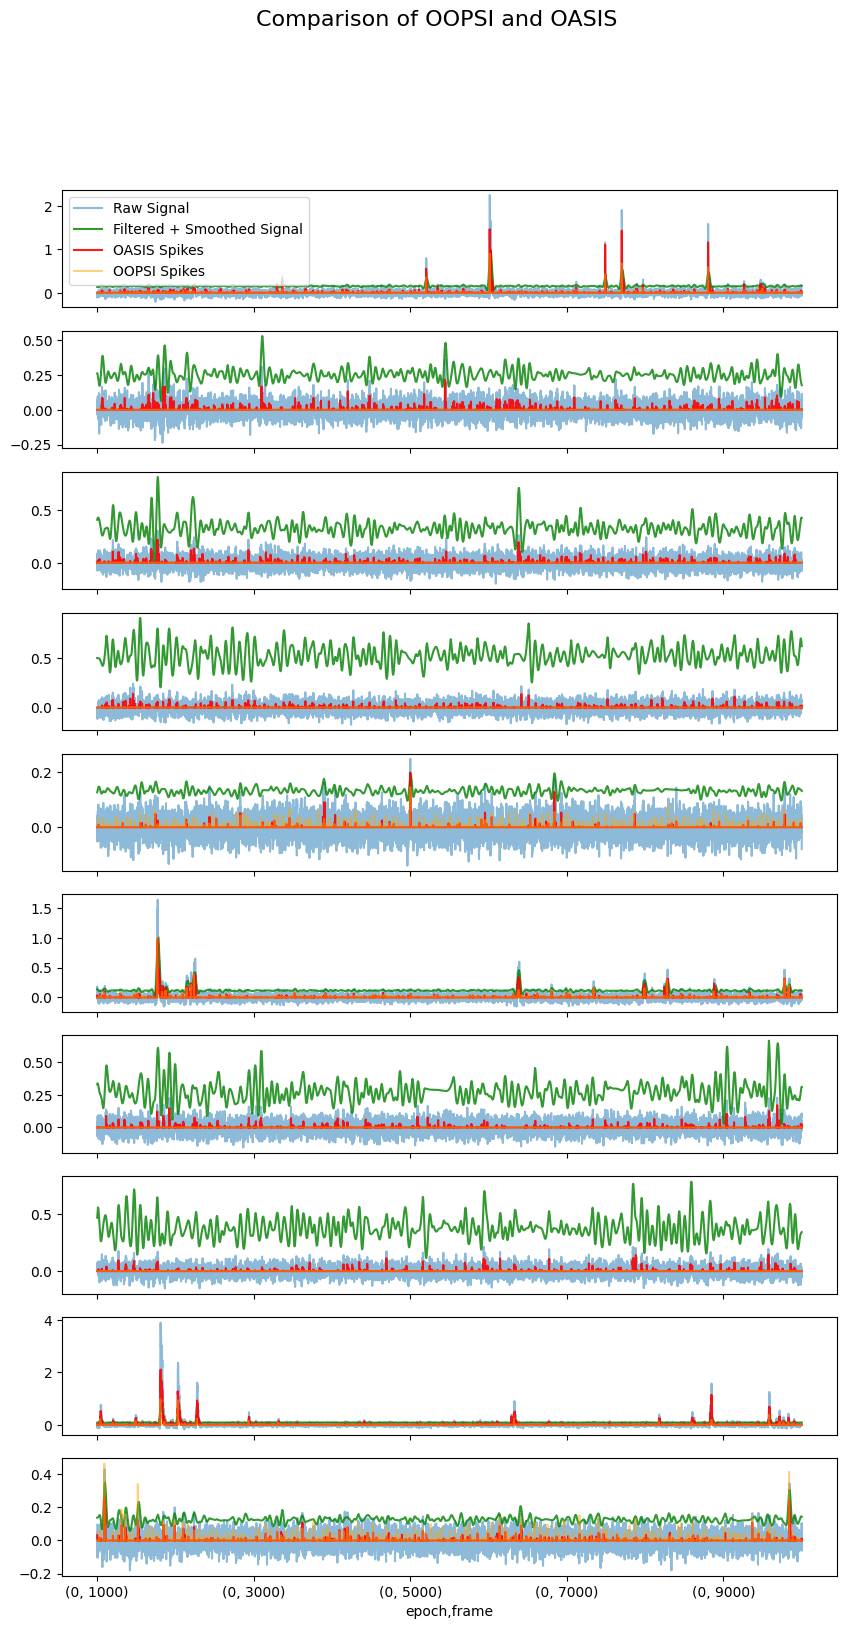

In [51]:
# plot raw and filtered signal epoch 1 of neuron 1, 15 and 30
neuron_indices = range(0, 10)  # Neuron indices to plot
fig, axes = plt.subplots(len(neuron_indices), 1, figsize=(10, 18), sharex=True)

interval = slice(1000, 10000)  # frames to plot

for i, neuron in enumerate(neuron_indices):
    ax = axes[i]
    df_raw.loc[(0, interval), neuron].plot(ax=ax, label="Raw Signal", alpha=0.5)

    df_preprocessed.loc[(0, interval), neuron].plot(
        ax=ax, label="Filtered + Smoothed Signal", color="green", alpha=0.8
    )
    df_oasis.loc[(0, interval), neuron].plot(
        ax=ax, label="OASIS Spikes", color="red", alpha=0.9
    )
    df_oopsi.loc[(0, interval), neuron].plot(
        ax=ax, label="OOPSI Spikes", color="orange", alpha=0.5
    )
    if i == 0:
        # outside plot
        ax.legend()

# set title for the entire figure
fig.suptitle("Comparison of OOPSI and OASIS", fontsize=16)

### 2.4 How do we interpret OOPSI and OASIS results?

OOPSI gives us spiking probility estimates and OASIS gives us discrete estimated calcium signals. How do we compare and interpret these results?

Distribution of OOPSI spikes:

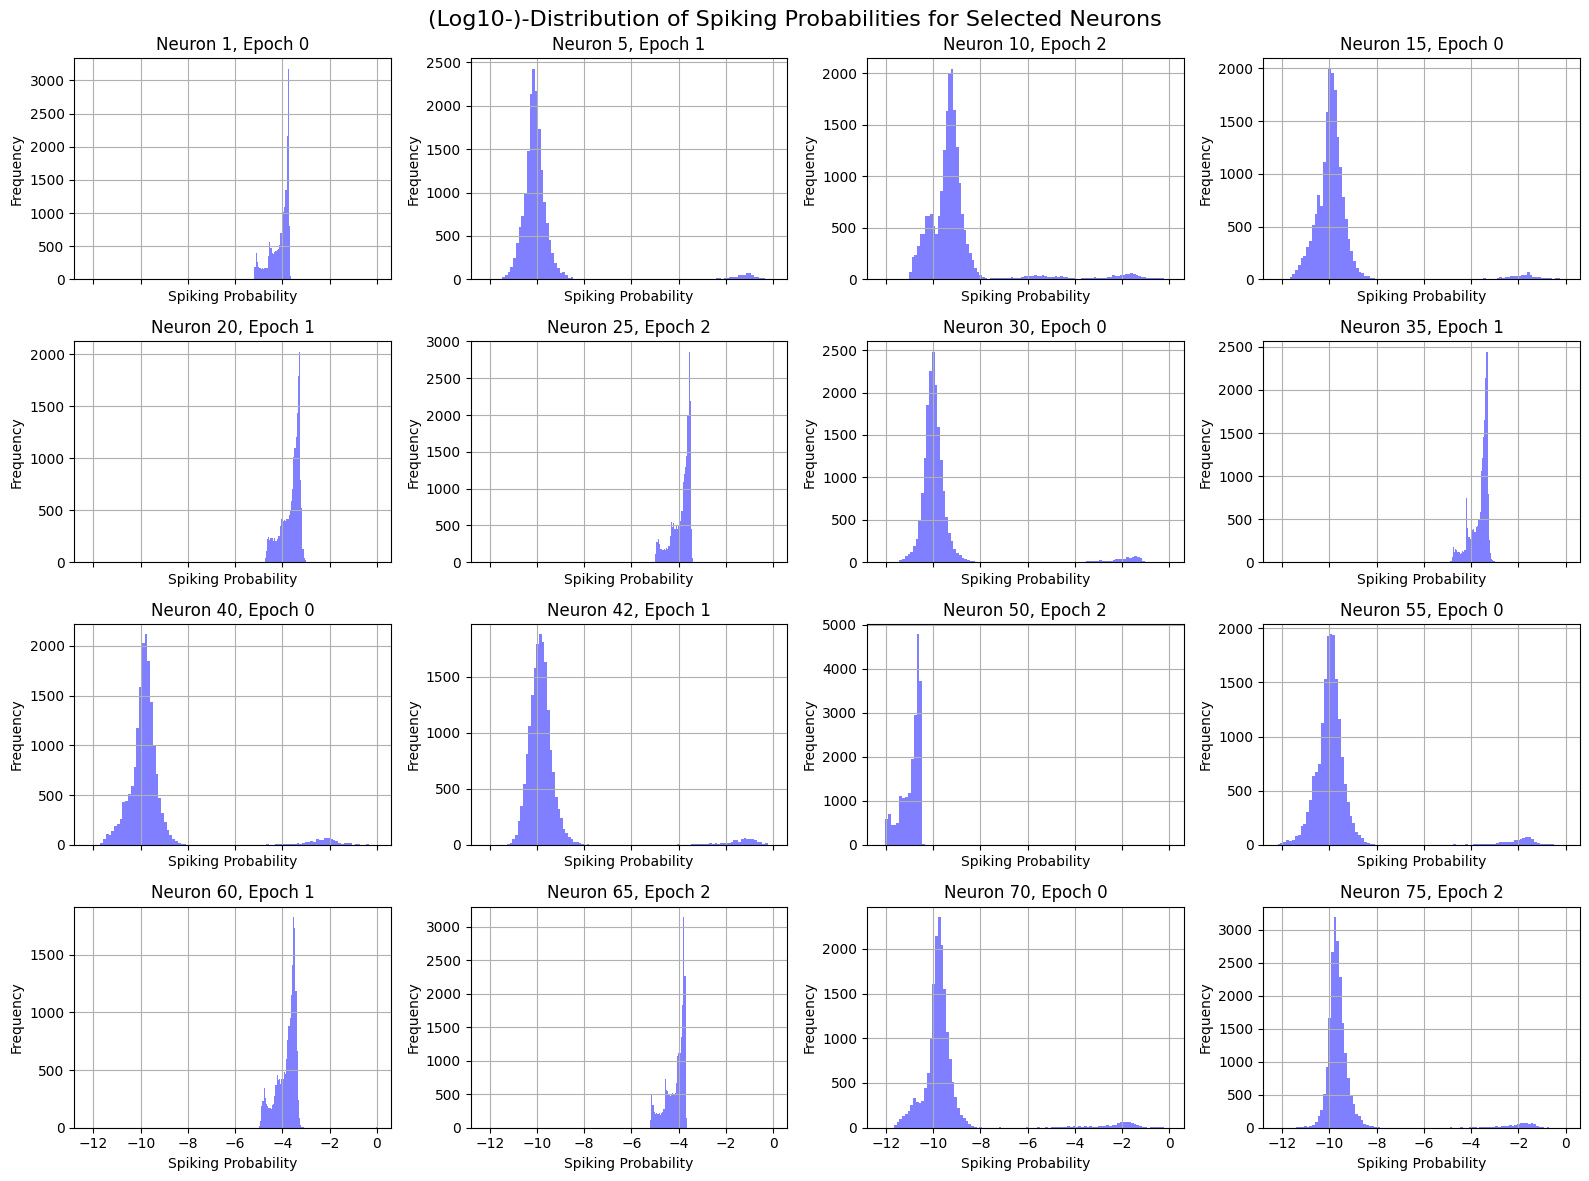

In [55]:
# Select 16 neuron indices and corresponding epochs (choose any for demonstration)
neuron_indices = [1, 5, 10, 15, 20, 25, 30, 35, 40, 42, 50, 55, 60, 65, 70, 75]
epoch_indices = [0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2]
fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()
for i, (neuron, epoch) in enumerate(zip(neuron_indices, epoch_indices)):
    ax = axes[i]
    np.log10(df_oopsi.loc[(epoch, slice(None)), neuron]).hist(
        bins=100, ax=ax, color="blue", alpha=0.5
    )
    ax.set_title(f"Neuron {neuron}, Epoch {epoch}")
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Spiking Probability")


fig.suptitle(
    "(Log10-)-Distribution of Spiking Probabilities for Selected Neurons",
    fontsize=16,
)
fig.tight_layout()

PLACEHOLDER: explain thresholding and how we can use it to detect spikes in the OOPSI data.

Distribution of OASIS spikes:

/var/folders/_w/fvv3yfg57mj4b3g4yftq72cr0000gn/T/ipykernel_29987/2653423907.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


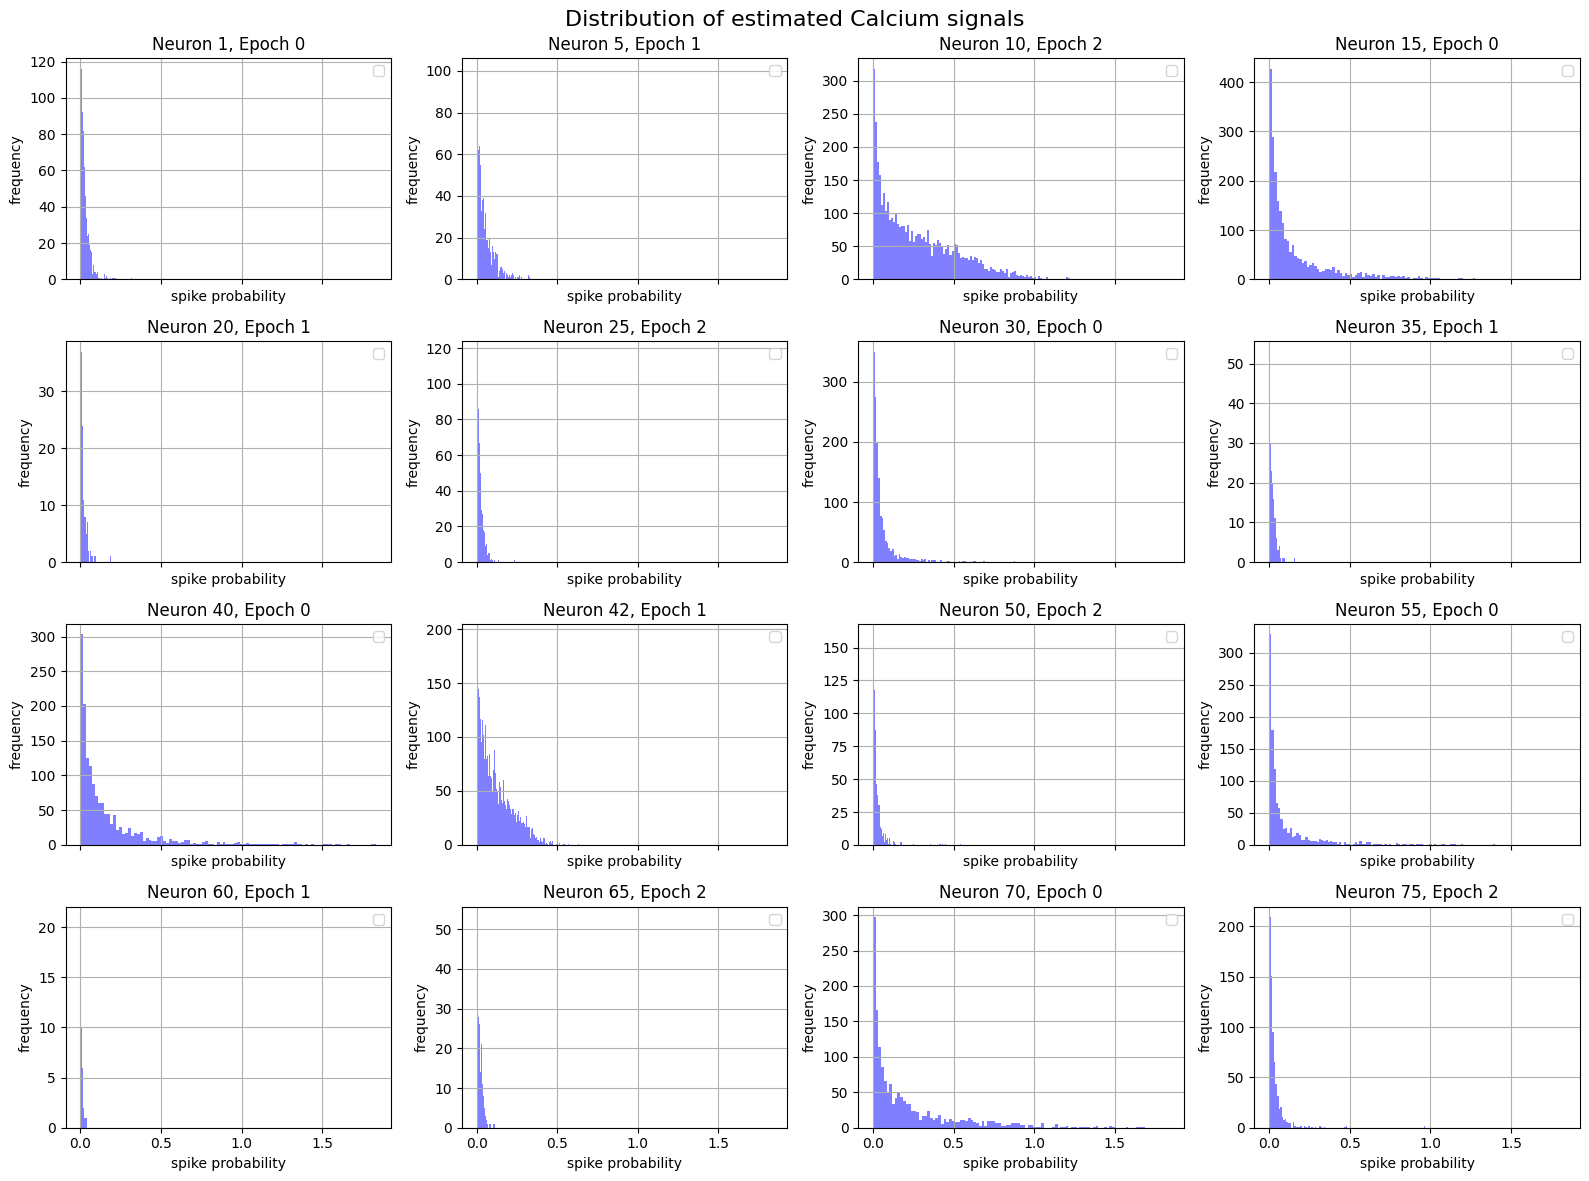

In [57]:
# plot histograms with threshold overlay
fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i, (neuron, epoch) in enumerate(zip(neuron_indices, epoch_indices)):
    ax = axes[i]
    probs = df_oasis.loc[(epoch, slice(None)), neuron]
    nonzero_probs = probs[probs > 1e-5]

    if len(nonzero_probs) > 0:
        nonzero_probs.hist(bins=100, ax=ax, color="blue", alpha=0.5)
        ax.set_title(f"Neuron {neuron}, Epoch {epoch}")
        ax.set_xlabel("spike probability")
        ax.set_ylabel("frequency")
        ax.legend()
    else:
        ax.set_title(f"Neuron {neuron}, Epoch {epoch}\n(no spikes)")
        ax.axis("off")

fig.suptitle("Distribution of estimated Calcium signals", fontsize=16)
fig.tight_layout()

## 3 Tuning Functions

In [ ]:
def extract_drifting_grating_trials(trials, df):
    """
    Extract trials corresponding to drifting grating stimuli and organize them into a DataFrame.

    Parameters:
    - trials: DataFrame containing trial metadata (e.g., start, end, frequency, direction, etc.)
    - df: DataFrame containing the neural activity data (e.g., df/F values)

    Returns:
    - DataFrame containing the extracted trials with metadata
    """

    def is_drifting_grating(start, end):
        """
        Check if the given start and end times correspond to a drifting grating stimulus.

        Parameters:
        - start: start time of the trial
        - end: end time of the trial

        Returns:
        - bool: True if the trial is a drifting grating stimulus, False otherwise
        """
        return (
            ((start > 747) and (end < 18775))
            or ((start > 48602) and (end < 66630))
            or ((start > 94659) and (end < 115215))
        )

    records = []
    for i, row in trials.iterrows():
        # Check if trial is a drifting grating stimulus
        if not is_drifting_grating(row.start, row.end):
            continue
        # Get all neurons in this epoch
        trial_df = df.loc[pd.IndexSlice[:, row.start : row.end], :]
        trial_df.insert(0, "trial", i)
        trial_df.insert(0, "freq", row.frequency)
        trial_df.insert(0, "dir", row.direction)
        trial_df.insert(0, "blank_sweep", row.blank_sweep)
        # Add trial number as index
        trial_df.reset_index(inplace=True, drop=False)
        trial_df.set_index(
            ["epoch", "trial", "frame", "freq", "dir", "blank_sweep"], inplace=True
        )
        # Add to records
        records.append(trial_df)
    # Create DataFrame from records
    return pd.concat(records, axis=0)

df_oasis_trials = extract_drifting_grating_trials(trials, df_oasis)
df_oasis_trials

neuron                                          0    1         2         3    \
epoch trial frame  freq dir   blank_sweep                                      
0     1     837    2.0  180.0 0.0          0.000000  0.0  0.000000  0.000000   
            838    2.0  180.0 0.0          0.000000  0.0  0.000000  0.005699   
            839    2.0  180.0 0.0          0.000000  0.0  0.000000  0.000000   
            840    2.0  180.0 0.0          0.000000  0.0  0.002154  0.000000   
            841    2.0  180.0 0.0          0.020808  0.0  0.064016  0.000000   
...                                             ...  ...       ...       ...   
2     596   115121 4.0  270.0 0.0          0.000000  0.0  0.000000  0.000000   
            115122 4.0  270.0 0.0          0.000000  0.0  0.000000  0.000000   
            115123 4.0  270.0 0.0          0.000000  0.0  0.000000  0.000000   
            115124 4.0  270.0 0.0          0.000000  0.0  0.000000  0.000000   
            115125 4.0  270.0 0.0          0.000000  0.0  0.000000  0.000000   

neuron                                     4         5         6    7    8    \
epoch trial frame  freq dir   blank_sweep                                      
0     1     837    2.0  180.0 0.0          0.0  0.000000  0.002696  0.0  0.0   
            838    2.0  180.0 0.0          0.0  0.000000  0.000000  0.0  0.0   
            839    2.0  180.0 0.0          0.0  0.000000  0.000000  0.0  0.0   
            840    2.0  180.0 0.0          0.0  0.023667  0.000000  0.0  0.0   
            841    2.0  180.0 0.0          0.0  0.288274  0.000000  0.0  0.0   
...                                        ...       ...       ...  ...  ...   
2     596   115121 4.0  270.0 0.0          0.0  0.000000  0.000000  0.0  0.0   
            115122 4.0  270.0 0.0          0.0  0.000000  0.000000  0.0  0.0   
            115123 4.0  270.0 0.0          0.0  0.000000  0.000000  0.0  0.0   
            115124 4.0  270.0 0.0          0.0  0.000000  0.000000  0.0  0.0   
            115125 4.0  270.0 0.0          0.0  0.000000  0.000000  0.0  0.0   

neuron                                     9    ...       96   97   98   99   \
epoch trial frame  freq dir   blank_sweep       ...                            
0     1     837    2.0  180.0 0.0          0.0  ...  0.000000  0.0  0.0  0.0   
            838    2.0  180.0 0.0          0.0  ...  0.000000  0.0  0.0  0.0   
            839    2.0  180.0 0.0          0.0  ...  0.000000  0.0  0.0  0.0   
            840    2.0  180.0 0.0          0.0  ...  0.050195  0.0  0.0  0.0   
            841    2.0  180.0 0.0          0.0  ...  0.000000  0.0  0.0  0.0   
...                                        ...  ...       ...  ...  ...  ...   
2     596   115121 4.0  270.0 0.0          0.0  ...  0.064153  0.0  0.0  0.0   
            115122 4.0  270.0 0.0          0.0  ...  0.000000  0.0  0.0  0.0   
            115123 4.0  270.0 0.0          0.0  ...  0.008223  0.0  0.0  0.0   
            115124 4.0  270.0 0.0          0.0  ...  0.000000  0.0  0.0  0.0   
            115125 4.0  270.0 0.0          0.0  ...  0.000000  0.0  0.0  0.0   

neuron                                     100       101  102  103       104  \
epoch trial frame  freq dir   blank_sweep                                      
0     1     837    2.0  180.0 0.0          0.0  0.000000  0.0  0.0  0.000000   
            838    2.0  180.0 0.0          0.0  0.000000  0.0  0.0  0.000000   
            839    2.0  180.0 0.0          0.0  0.000000  0.0  0.0  0.000000   
            840    2.0  180.0 0.0          0.0  0.000000  0.0  0.0  0.004931   
            841    2.0  180.0 0.0          0.0  0.000000  0.0  0.0  0.000000   
...                                        ...       ...  ...  ...       ...   
2     596   115121 4.0  270.0 0.0          0.0  0.000000  0.0  0.0  0.000000   
            115122 4.0  270.0 0.0          0.0  0.001907  0.0  0.0  0.000000   
            115123 4.0  270.0 0.0          0.0  0.000000  0.0  0.0  0.000000 

In [60]:
df_oopsi_trials = extract_drifting_grating_trials(trials, df_oopsi)
df_oopsi_trials

neuron                                              0         1         2    \
epoch trial frame  freq dir   blank_sweep                                     
0     1     837    2.0  180.0 0.0          3.383983e-11  0.000017  0.000002   
            838    2.0  180.0 0.0          6.478717e-11  0.000044  0.000002   
            839    2.0  180.0 0.0          7.476057e-11  0.000182  0.000001   
            840    2.0  180.0 0.0          1.199480e-10  0.000256  0.000003   
            841    2.0  180.0 0.0          1.254557e-10  0.000168  0.000002   
...                                                 ...       ...       ...   
2     596   115121 4.0  270.0 0.0          8.674585e-12  0.000635  0.000013   
            115122 4.0  270.0 0.0          7.780129e-12  0.000104  0.000056   
            115123 4.0  270.0 0.0          1.405647e-11  0.000144  0.000117   
            115124 4.0  270.0 0.0          3.326632e-12  0.000361  0.000038   
            115125 4.0  270.0 0.0          3.727692e-11  0.000576  0.000124   

neuron                                              3             4    \
epoch trial frame  freq dir   blank_sweep                               
0     1     837    2.0  180.0 0.0          7.530143e-04  3.066668e-10   
            838    2.0  180.0 0.0          8.894708e-04  6.267919e-11   
            839    2.0  180.0 0.0          8.220614e-05  6.503313e-11   
            840    2.0  180.0 0.0          7.484009e-04  6.751283e-11   
            841    2.0  180.0 0.0          5.673912e-04  4.043123e-11   
...                                                 ...           ...   
2     596   115121 4.0  270.0 0.0          3.572443e-11  2.277142e-10   
            115122 4.0  270.0 0.0          8.027675e-11  1.016592e-10   
            115123 4.0  270.0 0.0          2.816260e-11  1.112735e-10   
            115124 4.0  270.0 0.0          1.685173e-11  3.047476e-10   
            115125 4.0  270.0 0.0          4.893087e-11  3.286855e-10   

neuron                                              5             6    \
epoch trial frame  freq dir   blank_sweep                               
0     1     837    2.0  180.0 0.0          7.675643e-12  2.591821e-10   
            838    2.0  180.0 0.0          6.205712e-11  2.464084e-11   
            839    2.0  180.0 0.0          7.505657e-11  1.174008e-11   
            840    2.0  180.0 0.0          8.488668e-11  2.308089e-10   
            841    2.0  180.0 0.0          3.381532e-01  1.652755e-10   
...                                                 ...           ...   
2     596   115121 4.0  270.0 0.0          1.403555e-10  1.242807e-10   
            115122 4.0  270.0 0.0          1.225179e-10  1.135086e-10   
            115123 4.0  270.0 0.0          1.145750e-10  9.240634e-11   
            115124 4.0  270.0 0.0          1.677703e-10  1.366821e-10   
            115125 4.0  270.0 0.0          1.000374e-10  8.904823e-12   

neuron                                          7             8    \
epoch trial frame  freq dir   blank_sweep                           
0     1     837    2.0  180.0 0.0          0.000352  1.706645e-11   
            838    2.0  180.0 0.0          0.000135  1.747143e-11   
            839    2.0  180.0 0.0          0.000548  1.763406e-11   
            840    2.0  180.0 0.0          0.000071  1.850104e-11   
            841    2.0  180.0 0.0          0.000096  1.924365e-11   
...                                             ...           ...   
2     596   115121 4.0  270.0 0.0          0.000128  2.318663e-11   
            115122 4.0  270.0 0.0          0.000039  2.222360e-11   
            115123 4.0  270.0 0.0          0.000075  2.426316e-11   
            115124 4.0  270.0 0.0          0.000174  2.978082e-11   
            115125 4.0  270.0 0.0          0.000063  3.288525e-11   

neuron                                              9    ...           96   \
epoch trial frame  freq dir   blank_sweep                ...                 
0     1     837   

In [62]:
# vonMises tuning curve estimation
def vonMises(
    theta: np.ndarray, alpha: float, kappa: float, ny: float, phi: float
) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.
    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    theta, phi = np.deg2rad(theta), np.deg2rad(phi)

    return np.exp(
        alpha + kappa * (np.cos(2 * (theta - phi)) - 1) + ny * (np.cos(theta - phi) - 1)
    )


def tuningCurve(group, tuning_parameter=None):
    """Calculate tuning curve for a group of trials."""
    spike_counts = group.groupby(["trial", tuning_parameter]).sum()
    mean_counts = group.groupby(tuning_parameter).sum()

    α0 = np.log(np.max(mean_counts.values) + 1e-3)
    ϕ0 = mean_counts.idxmax()
    p0 = [α0, 1.0, 1.0, ϕ0]
    p, _ = opt.curve_fit(
        vonMises,
        spike_counts.index.get_level_values(tuning_parameter).values,
        spike_counts.values,
        p0=p0,
        maxfev=10000,
    )
    return pd.Series(p, index=["α", "κ", "ν", "ϕ"])


# compute tuning curves for OOPSI data
df_tuning_curves_oopsi = (
    df_oopsi_trials.stack("neuron")
    .groupby("neuron")
    .apply(tuningCurve, "dir")
    .to_frame()
    .unstack(level=1)
)
# remove the first level of the index
df_tuning_curves_oopsi.columns = df_tuning_curves_oopsi.columns
df_tuning_curves_oopsi.columns.name = "parameter"
df_tuning_curves_oopsi

0                                
               α         κ         ν           ϕ
neuron                                          
0      -2.756716  0.549210  0.185610  269.474799
1      -3.910264  0.440360  0.280331  314.156429
2      -5.008034  0.045165  0.086013  302.567308
3      -4.606825  0.107923  0.008551  203.388439
4      -2.717167  0.117501  0.161364  141.294536
...          ...       ...       ...         ...
101    -3.208546  0.080158  0.051028  316.539284
102    -1.707261  0.570310  0.365840   51.763782
103    -3.910262  0.573613  0.435226  316.460192
104    -2.993928  0.173130  0.025691  263.210271
105    -4.902857  0.046270  0.084010  297.379504

[106 rows x 4 columns]

In [63]:
# compute tuning curves for OASIS data
df_tuning_curves_oasis = (
    df_oasis_trials.stack("neuron")
    .groupby("neuron")
    .apply(tuningCurve, "dir")
    .to_frame()
    .unstack(level=1)
)
# remove the first level of the index
df_tuning_curves_oasis.columns = df_tuning_curves_oasis.columns.droplevel(0)
df_tuning_curves_oasis.columns.name = "parameter"
df_tuning_curves_oasis

parameter,α,κ,ν,ϕ
neuron,,,,
0,-0.719520,1.075613,0.462389,263.228433
1,-2.087602,0.128692,0.071210,33.693985
2,-1.486163,0.652675,0.182518,1.132305
3,-2.360499,0.313327,0.214276,41.066484
4,-1.853140,1.052283,0.920383,138.699910
...,...,...,...,...
101,-2.836890,0.269598,0.187744,8.733501
102,0.144753,1.825886,1.011813,51.989041
103,-2.230085,0.154718,0.093774,207.627994


In [79]:
def plot_tuning_curves(df_trials, df_tuning_curves, num_neurons=4):
    """
    Plot tuning curves, spike counts, and mean counts per frequency for randomly selected neurons.

    Parameters:
    - df_trials: DataFrame containing trial data with spike counts and directions.
    - df_tuning_curves: DataFrame containing tuning curve parameters for neurons.
    - num_neurons: Number of neurons to randomly select for plotting.
    """
    neurons = random.sample(range(df_tuning_curves.shape[0]), num_neurons)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    for i, neuron in enumerate(neurons):
        ax = axes[i]
        theta = np.linspace(0, 360, 100)

        ax.plot(
            theta,
            vonMises(
                theta,
                df_tuning_curves_oasis.loc[neuron, "α"],
                df_tuning_curves_oasis.loc[neuron, "κ"],
                df_tuning_curves_oasis.loc[neuron, "ν"],
                df_tuning_curves_oasis.loc[neuron, "ϕ"],
            ),
            label="Von Mises Fit",
            color="orange",
            alpha=0.7,
        )
        # scatterplot spike counts for individual trials
        spike_counts = df_oasis_trials.loc[:, neuron].groupby(["trial", "dir"]).sum()
        ax.scatter(
            spike_counts.index.get_level_values("dir").values,
            spike_counts.values,
            label="Spike Counts",
            color="blue",
            alpha=0.5,
        )

        # plot mean counts per direction
        mean_counts = df_oasis_trials.loc[:, neuron].groupby(["dir"]).mean()
        ax.scatter(
            spike_counts.index.get_level_values("dir").unique(),
            mean_counts.values,
            label="Mean Count per Direction",
            color="red",
            alpha=0.5,
        )

        ax.set_title(f"Neuron {neuron}")
        ax.set_xlabel("Direction (degrees)")
        ax.set_ylabel("Spike Count")
        ax.legend()
    fig.tight_layout()

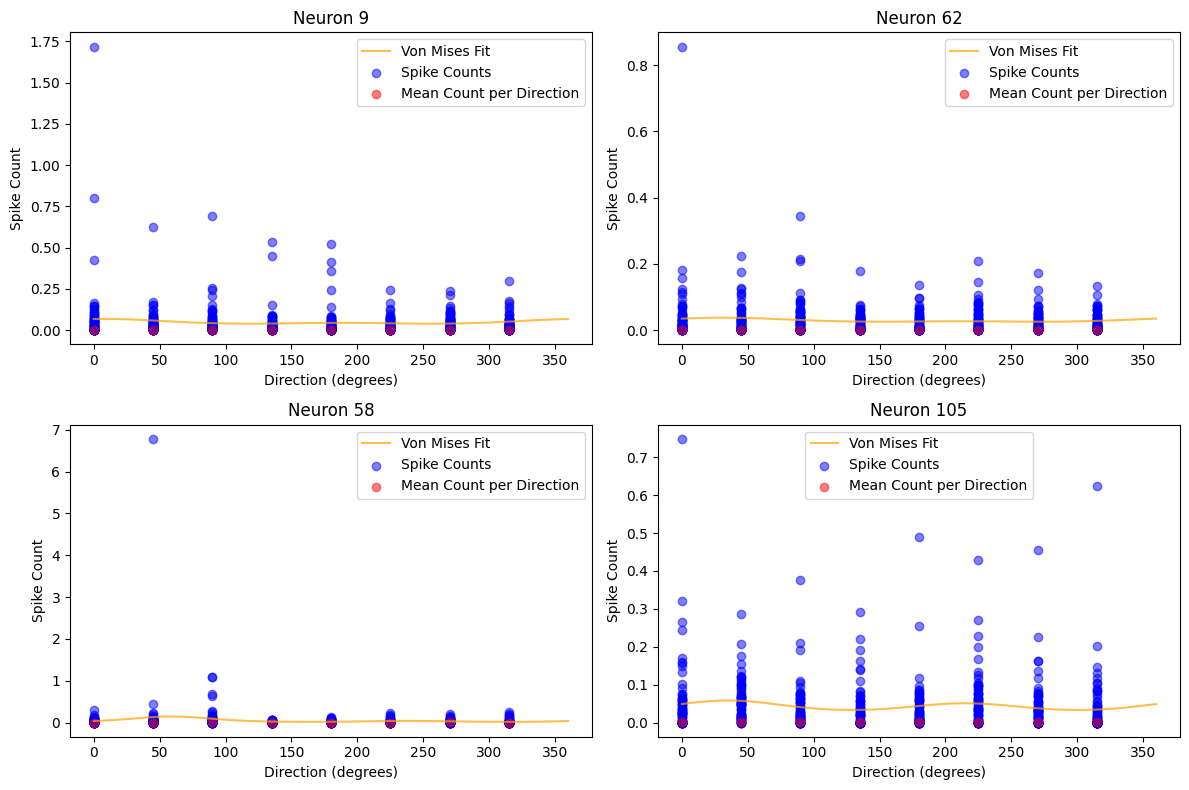

In [80]:
plot_tuning_curves(df_oopsi_trials, df_tuning_curves_oopsi, num_neurons=4)

## 4 Statistical Testing
### 4.1 Permutation Test

In [ ]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Permutation test for direction/orientation tuning."""
    unique_dirs = np.sort(np.unique(dirs))
    m = np.array([np.mean(counts[dirs == d]) for d in unique_dirs])
    v = np.exp(1j * psi * np.deg2rad(unique_dirs))
    q = np.dot(m, v)
    q_mag = np.abs(q)

    rng = np.random.default_rng(random_seed)
    qdistr = np.zeros(niters)
    for i in range(niters):
        shuffled_counts = rng.permutation(counts)
        m_perm = np.array([np.mean(shuffled_counts[dirs == d]) for d in unique_dirs])
        qdistr[i] = np.abs(np.dot(m_perm, v))

    p = np.mean(qdistr > q_mag)

    if show:
        import matplotlib.pyplot as plt

        plt.hist(qdistr, bins=30, alpha=0.7)
        plt.axvline(q_mag, color="r", linestyle="--")
        plt.title(f"ψ={psi} p={p:.4f}")
        plt.show()

    return p, q_mag, qdistr

In [ ]:
def compute_tuning_results(df_trials):
    """
    Compute tuning results for neurons based on direction and orientation.

    Parameters:
    - df_trials: DataFrame containing trial data with spike counts and directions.

    Returns:
    - DataFrame with tuning results including p-values, q-values, and significance.
    """
    results = []

    for neuron in tqdm(df_trials.columns):
        counts = df_trials[neuron].values
        dirs = df_trials.index.get_level_values("dir").values

        p_dir, q_dir, _ = testTuning(counts, dirs, psi=1, show=False)
        p_ori, q_ori, _ = testTuning(counts, dirs, psi=2, show=False)

        results.append(
            {
                "neuron": neuron,
                "p_dir": p_dir,
                "|q|_dir": q_dir,
                "p_ori": p_ori,
                "|q|_ori": q_ori,
                "sig_dir": p_dir < 0.05,
                "sig_ori": p_ori < 0.05,
            }
        )

    # convert to DataFrame
    df_test_results = pd.DataFrame(results).set_index("neuron")
    return df_test_results

In [ ]:
# run the tuning test
df_test_results_oasis = compute_tuning_results(df_oasis_trials)
df_test_results_oopsi = compute_tuning_results(df_oopsi_trials)

### 4.2 Spatial Structure of Neurons

In [ ]:
# OASIS tuning test results

# filter for significant direction tuned neurons in df_tuning_curves from df_test_results
df_direction_tuned = df_test_results_oasis[df_test_results_oasis["sig_dir"]].index
df_tuning_curves_copy_dir = df.copy()
df_tuning_curves_copy_dir = df_tuning_curves_oasis.loc[df_direction_tuned, :]
print(df_tuning_curves_copy_dir)
print(len(df_tuning_curves_oasis), len(df_tuning_curves_copy_dir))

# filter for significant orientation tuned neurons in df_tuning_curves from df_test_results
df_orientation_tuned = df_test_results_oasis[df_test_results_oasis["sig_ori"]].index
df_tuning_curves_copy_ori_oasis = df_tuning_curves_oasis.copy()
df_tuning_curves_copy_ori_oasis = df_tuning_curves_copy_ori_oasis.loc[df_orientation_tuned, :]
df_tuning_curves_copy_ori_oasis

# OOPSI tuning test results

# filter for significant direction tuned neurons in df_tuning_curves from df_test_results
df_direction_tuned = df_test_results_oopsi[df_test_results_oopsi["sig_dir"]].index
df_tuning_curves_copy_dir = df.copy()
df_tuning_curves_copy_dir = df_tuning_curves_oopsi.loc[df_direction_tuned, :]
print(df_tuning_curves_copy_dir)
print(len(df_tuning_curves_oopsi), len(df_tuning_curves_copy_dir))

# filter for significant orientation tuned neurons in df_tuning_curves from df_test_results
df_orientation_tuned = df_test_results_oopsi[df_test_results_oopsi["sig_ori"]].index
df_tuning_curves_copy_ori_oopsi = df_tuning_curves_oopsi.copy()
df_tuning_curves_copy_ori_oopsi = df_tuning_curves_copy_ori_oopsi.loc[df_orientation_tuned, :]
df_tuning_curves_copy_ori_oopsi

In [84]:
data["max_projection"]

array([[174, 171, 163, ..., 247, 242, 216],
       [177, 176, 176, ..., 288, 237, 236],
       [160, 172, 176, ..., 275, 257, 240],
       ...,
       [218, 231, 230, ..., 592, 460, 426],
       [214, 221, 227, ..., 539, 433, 396],
       [215, 244, 235, ..., 392, 384, 359]],
      shape=(512, 512), dtype=uint16)

In [ ]:
### needs to be a function to handle dirs and frequency and different data types ###

def get_centroids_numpy(roi_masks):
    centroids = []
    for mask in roi_masks:
        y, x = np.nonzero(mask)
        if len(x) > 0 and len(y) > 0:
            cx = np.mean(x)
            cy = np.mean(y)
            centroids.append((cx, cy))
        else:
            centroids.append((np.nan, np.nan))
    return np.array(centroids)


roi_masks = data["roi_masks"]
centroids = get_centroids_numpy(roi_masks)

# Direction selectivity (ϕ)
phi = df_tuning_curves_copy_dir_oasis["ϕ"].values
phi_norm = (phi % 360) / 360
colors = hsv_to_rgb(
    np.stack([phi_norm, np.ones_like(phi_norm), np.ones_like(phi_norm)], axis=1)
)

fig, ax = plt.subplots(figsize=(9, 8))
ax.imshow(data["max_projection"], cmap="gray", alpha=0.3)

for (x, y), color in zip(centroids, colors):
    if not np.isnan(x) and not np.isnan(y):
        circle = plt.Circle(
            (x, y), radius=4, color=color, edgecolor="black", linewidth=0.5
        )
        ax.add_patch(circle)

ax.set_title("Neuron Positions Color-Coded by Direction Selectivity (ϕ)")
ax.axis("off")

# Create  colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

hue = np.linspace(0, 1, 360).reshape(-1, 1)
hsv = np.repeat(hue, 10, axis=1)
rgb = hsv_to_rgb(np.stack([hsv, np.ones_like(hsv), np.ones_like(hsv)], axis=-1))
cax.imshow(rgb, aspect="auto", origin="lower")

cax.set_yticks([0, 90, 180, 270, 359])
cax.set_yticklabels(["0°", "90°", "180°", "270°", "360°"])
cax.set_xticks([])
cax.set_title("ϕ", fontsize=10)
cax.tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.show()

NameError: name 'df_tuning_curves_copy_dir' is not defined

In [ ]:
from matplotlib.cm import ScalarMappable

freq = df_tuning_curves["ν"].values  # Frequency values
freq_norm = (freq - freq.min()) / (freq.max() - freq.min())  # normalize to [0,1]
cmap = plt.cm.plasma  # Use same colormap for colorbar and scatter
colors = cmap(freq_norm)

# Frequency scale for colorbar
norm = Normalize(vmin=freq.min(), vmax=freq.max())
sm = ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data["max_projection"], cmap="gray", alpha=0.3)

for (x, y), color in zip(centroids, colors):
    if not np.isnan(x) and not np.isnan(y):
        circle = plt.Circle(
            (x, y), radius=4, facecolor=color, edgecolor="black", linewidth=0.5
        )
        ax.add_patch(circle)

ax.set_title("Neuron Positions Color-Coded by Frequency Selectivity (ϕ)")
ax.axis("off")

# Add colorbar to the same figure
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.046, pad=0.04)
cbar.set_label("Frequency (Hz)")

plt.tight_layout()
plt.show()